# DQN


### Training of DQN in Tensorflow
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- deny: 9
- closing: 5
- welcome: 8
- confirm_answer: 3
- confirm_question: 2


### slot set

In [3]:
#
slots_set_path = "./parser/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 7
Sample of dict:
- travelers: 4
- destination1: 0
- taskcomplete: 6
- ticket: 5
- origin1: 3


### flight dic: info about flights

In [4]:
#
flight_kb_path = "./parser/fkb.json.p"
flight_kb = pickle.load(open(flight_kb_path, 'rb'), encoding="latin")
sample_dict(flight_kb, sample_size=1)

keys = 1000
Sample of dict:
- 673: {'travelers': '3', 'flightDate1': '0', 'destination1': 'SHA', 'origin1': 'YYZ', 'flightDate2': '3'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./parser/flight.nl.pairs.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

eva_metric: 2
split_method: 1
hidden_size: 100
momentum: 0.1
slot_rep: 1
sdgtype: rmsprop
max_epochs: 200
batch_size: 16
slot_set: data/slot_set.txt
pretrained_model_path: None
cv_fold: 6
save_check_point: 20
model: lstm_tanh
feed_recurrence: 0
decay_rate: 0.999
learning_rate: 0.001
dia_slot_val: 2
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
grad_clip: -0.0001
act_set: data/dia_acts.txt
valid_test: 0
trained_model_path: None
init_rnn: 0
write_model_dir: .\checkpoints\template\07102016\
check_point: 20
reg_cost: 0.001
activation_func: relu
smooth_eps: 1e-08


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './parser/fg.json.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'request_slots': {}, 'diaact': 'request', 'inform_slots': {'travelers': '4', 'flightDate1': '2', 'destination1': 'MCO', 'origin1': 'MUC', 'flightDate2': '3'}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a flights dictionary for user simulator - slot:possible values

In [10]:
#
flight_dict_path = './parser/dicts.v3.p'
flight_dictionary = pickle.load(open(flight_dict_path, 'rb'), encoding="latin")
samples = sample_dict(flight_dictionary, sample_size=1)

keys = 20
Sample of dict:
- price: ['$20', '$10', 'cheapest', 'adult price is 8', '32']


###  Create a User

In [11]:
user = RuleSimulator(flight_dictionary, act_set, slot_set, goal_set, usersim_params)
# user = AlternateSimulator(flight_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [13]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(flight_kb, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(flight_kb, act_set, slot_set, agent_params)

agent.set_nlg_model(nlg_model)

80


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, flight_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 20
# num_episodes = 60

In [16]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [17]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [18]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [19]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(600, status)

warm_start starting ...
Warm_Start 20 epochs, success rate 0.2, ave reward 14.8, ave turns 2.8
Current experience replay buffer size 140
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -57.22, ave turns 36.44
Train on : 1983
- cur bellman err 8.7786, experience replay pool 1983
Simulation success rate 0.0, Ave reward -57.22, Ave turns 36.44, Best success rate 0
Progress: 1 / 600, Success rate: 0 / 1 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -40.0, ave turns 2.0
Train on : 2083
- cur bellman err 11.1879, experience replay pool 2083
Simulation success rate 0.0, Ave reward -40.0, Ave turns 2.0, Best success rate 0
Progress: 2 / 600, Success rate: 0 / 2 Avg reward: -50.00 Avg turns: 22.00
----------------- Episode: 2 ----------------- 
simulation success rate 0.0, ave reward -41.0, ave turns 4.0
Train on : 2283
- cur bellman er

simulation success rate 1.0, ave reward 74.0, ave turns 14.0
simulation success rate 1.0, ave reward 74.0, ave turns 14.0
Train on : 700
- cur bellman err 0.0523, experience replay pool 700
Simulation success rate 1.0, Ave reward 74.0, Ave turns 14.0, Best success rate 0
Progress: 23 / 600, Success rate: 10 / 23 Avg reward: 1.17 Avg turns: 24.00
----------------- Episode: 23 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.07, ave turns 13.86
simulation success rate 1.0, ave reward 74.03, ave turns 13.94
Train on : 697
- cur bellman err 0.0565, experience replay pool 697
Simulation success rate 1.0, Ave reward 74.07, Ave turns 13.86, Best success rate 0
Progress: 24 / 600, Success rate: 11 / 24 Avg reward: 4.21 Avg turns: 23.58
----------------- Episode: 24 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.43, ave turns 13.14
simulation success rate 1.0, ave reward 74.55, ave turns 12.9
Train on : 645
- cur bellman err 0.15

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0059, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 43 / 600, Success rate: 30 / 43 Avg reward: 35.42 Avg turns: 18.60
----------------- Episode: 43 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0061, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 44 / 600, Success rate: 31 / 44 Avg reward: 36.32 Avg turns: 18.45
----------------- Episode: 44 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0044, exp

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0039, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 63 / 600, Success rate: 50 / 63 Avg reward: 47.98 Avg turns: 16.51
----------------- Episode: 63 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0037, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 64 / 600, Success rate: 51 / 64 Avg reward: 48.41 Avg turns: 16.44
----------------- Episode: 64 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0030, exp

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0040, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 83 / 600, Success rate: 70 / 83 Avg reward: 54.49 Avg turns: 15.42
----------------- Episode: 83 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0038, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 84 / 600, Success rate: 71 / 84 Avg reward: 54.74 Avg turns: 15.38
----------------- Episode: 84 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0045, exp

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0027, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 103 / 600, Success rate: 90 / 103 Avg reward: 58.48 Avg turns: 14.76
----------------- Episode: 103 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0028, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 104 / 600, Success rate: 91 / 104 Avg reward: 58.63 Avg turns: 14.73
----------------- Episode: 104 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.002

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0037, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 123 / 600, Success rate: 110 / 123 Avg reward: 61.16 Avg turns: 14.31
----------------- Episode: 123 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0049, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 124 / 600, Success rate: 111 / 124 Avg reward: 61.27 Avg turns: 14.29
----------------- Episode: 124 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0035, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 143 / 600, Success rate: 130 / 143 Avg reward: 63.10 Avg turns: 13.99
----------------- Episode: 143 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0040, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 144 / 600, Success rate: 131 / 144 Avg reward: 63.18 Avg turns: 13.97
----------------- Episode: 144 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0040, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 163 / 600, Success rate: 150 / 163 Avg reward: 64.56 Avg turns: 13.74
----------------- Episode: 163 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0033, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 164 / 600, Success rate: 151 / 164 Avg reward: 64.62 Avg turns: 13.73
----------------- Episode: 164 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0080, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 183 / 600, Success rate: 170 / 183 Avg reward: 65.70 Avg turns: 13.55
----------------- Episode: 183 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0080, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 184 / 600, Success rate: 171 / 184 Avg reward: 65.75 Avg turns: 13.54
----------------- Episode: 184 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0042, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 203 / 600, Success rate: 190 / 203 Avg reward: 66.62 Avg turns: 13.40
----------------- Episode: 203 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0037, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 204 / 600, Success rate: 191 / 204 Avg reward: 66.66 Avg turns: 13.39
----------------- Episode: 204 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0033, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 223 / 600, Success rate: 210 / 223 Avg reward: 67.37 Avg turns: 13.27
----------------- Episode: 223 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0042, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 224 / 600, Success rate: 211 / 224 Avg reward: 67.40 Avg turns: 13.27
----------------- Episode: 224 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0033, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 243 / 600, Success rate: 230 / 243 Avg reward: 68.00 Avg turns: 13.17
----------------- Episode: 243 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0043, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 244 / 600, Success rate: 231 / 244 Avg reward: 68.02 Avg turns: 13.16
----------------- Episode: 244 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0033, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 263 / 600, Success rate: 250 / 263 Avg reward: 68.53 Avg turns: 13.08
----------------- Episode: 263 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0025, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 264 / 600, Success rate: 251 / 264 Avg reward: 68.55 Avg turns: 13.08
----------------- Episode: 264 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0041, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 283 / 600, Success rate: 270 / 283 Avg reward: 68.99 Avg turns: 13.00
----------------- Episode: 283 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0033, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 284 / 600, Success rate: 271 / 284 Avg reward: 69.01 Avg turns: 13.00
----------------- Episode: 284 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0039, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 303 / 600, Success rate: 290 / 303 Avg reward: 69.38 Avg turns: 12.94
----------------- Episode: 303 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0048, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 304 / 600, Success rate: 291 / 304 Avg reward: 69.40 Avg turns: 12.93
----------------- Episode: 304 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0036, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 323 / 600, Success rate: 310 / 323 Avg reward: 69.73 Avg turns: 12.88
----------------- Episode: 323 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0028, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 324 / 600, Success rate: 311 / 324 Avg reward: 69.75 Avg turns: 12.88
----------------- Episode: 324 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0038, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 343 / 600, Success rate: 330 / 343 Avg reward: 70.04 Avg turns: 12.83
----------------- Episode: 343 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0027, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 344 / 600, Success rate: 331 / 344 Avg reward: 70.05 Avg turns: 12.83
----------------- Episode: 344 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0024, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 363 / 600, Success rate: 350 / 363 Avg reward: 70.31 Avg turns: 12.78
----------------- Episode: 363 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0027, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 364 / 600, Success rate: 351 / 364 Avg reward: 70.32 Avg turns: 12.78
----------------- Episode: 364 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0024, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 383 / 600, Success rate: 370 / 383 Avg reward: 70.56 Avg turns: 12.74
----------------- Episode: 383 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0034, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 384 / 600, Success rate: 371 / 384 Avg reward: 70.57 Avg turns: 12.74
----------------- Episode: 384 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0018, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 403 / 600, Success rate: 390 / 403 Avg reward: 70.78 Avg turns: 12.70
----------------- Episode: 403 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0024, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 404 / 600, Success rate: 391 / 404 Avg reward: 70.79 Avg turns: 12.70
----------------- Episode: 404 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0041, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 423 / 600, Success rate: 410 / 423 Avg reward: 70.98 Avg turns: 12.67
----------------- Episode: 423 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0040, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 424 / 600, Success rate: 411 / 424 Avg reward: 70.99 Avg turns: 12.67
----------------- Episode: 424 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0023, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 443 / 600, Success rate: 430 / 443 Avg reward: 71.16 Avg turns: 12.64
----------------- Episode: 443 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0017, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 444 / 600, Success rate: 431 / 444 Avg reward: 71.17 Avg turns: 12.64
----------------- Episode: 444 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0034, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 463 / 600, Success rate: 450 / 463 Avg reward: 71.32 Avg turns: 12.61
----------------- Episode: 463 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0035, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 464 / 600, Success rate: 451 / 464 Avg reward: 71.33 Avg turns: 12.61
----------------- Episode: 464 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0020, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 483 / 600, Success rate: 470 / 483 Avg reward: 71.48 Avg turns: 12.59
----------------- Episode: 483 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0025, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 484 / 600, Success rate: 471 / 484 Avg reward: 71.48 Avg turns: 12.59
----------------- Episode: 484 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0024, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 503 / 600, Success rate: 490 / 503 Avg reward: 71.62 Avg turns: 12.56
----------------- Episode: 503 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0037, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 504 / 600, Success rate: 491 / 504 Avg reward: 71.62 Avg turns: 12.56
----------------- Episode: 504 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0019, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 523 / 600, Success rate: 510 / 523 Avg reward: 71.75 Avg turns: 12.54
----------------- Episode: 523 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0012, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 524 / 600, Success rate: 511 / 524 Avg reward: 71.75 Avg turns: 12.54
----------------- Episode: 524 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0024, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 543 / 600, Success rate: 530 / 543 Avg reward: 71.87 Avg turns: 12.52
----------------- Episode: 543 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0037, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 544 / 600, Success rate: 531 / 544 Avg reward: 71.87 Avg turns: 12.52
----------------- Episode: 544 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0018, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 563 / 600, Success rate: 550 / 563 Avg reward: 71.98 Avg turns: 12.50
----------------- Episode: 563 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0015, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 564 / 600, Success rate: 551 / 564 Avg reward: 71.98 Avg turns: 12.50
----------------- Episode: 564 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0015, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 583 / 600, Success rate: 570 / 583 Avg reward: 72.08 Avg turns: 12.49
----------------- Episode: 583 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0016, experience replay pool 600
Simulation success rate 1.0, Ave reward 75.0, Ave turns 12.0, Best success rate 0
Progress: 584 / 600, Success rate: 571 / 584 Avg reward: 72.09 Avg turns: 12.49
----------------- Episode: 584 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
simulation success rate 1.0, ave reward 75.0, ave turns 12.0
Train on : 600
- cur bellman err 0.0

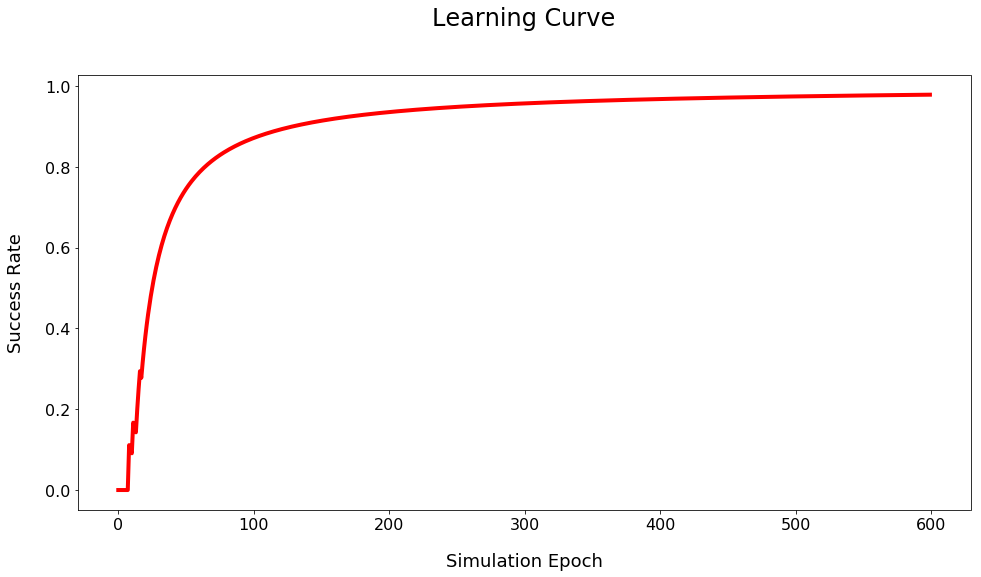

In [20]:
draw_learning_curve(curve)

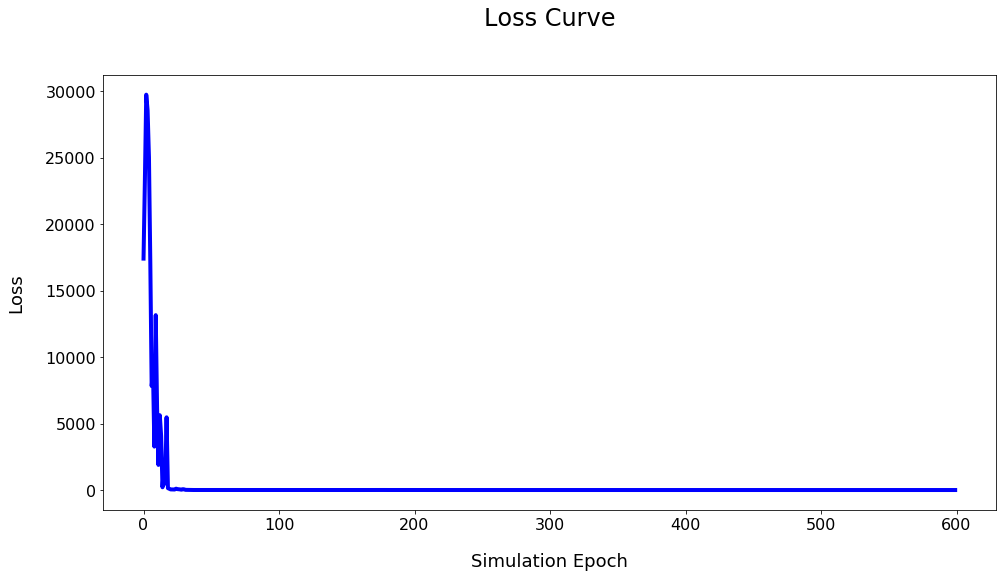

In [21]:
draw_loss_curve(losses)

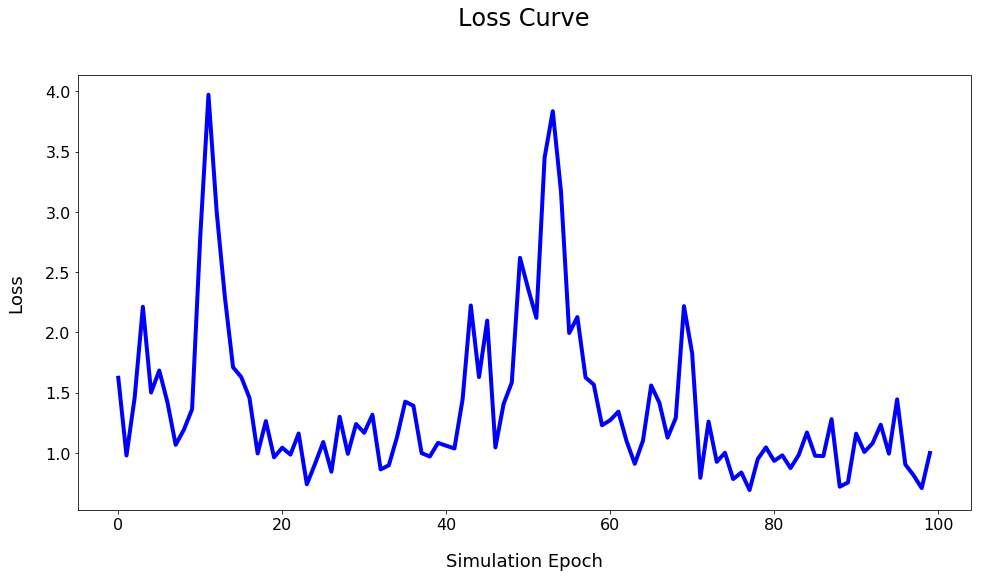

In [22]:
draw_loss_curve(losses[-100:])

In [23]:
saver = tf.train.Saver()

In [24]:
saver.save(agent.model.sess, "trained_model/tf_400/", global_step = 400)  

'trained_model/tf_400/-400'